# Controlled Anomalies Time Series (CATS) Dataset

- Source and description: https://zenodo.org/records/8338435

In [21]:
from typing import List
import matplotlib
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from config import data_raw_folder, data_processed_folder
from timeeval import DatasetManager
from timeeval.datasets import Datasets, DatasetAnalyzer, DatasetRecord

In [22]:
plt.rcParams["figure.figsize"] = (20, 10)

In [23]:
dataset_collection_name = "CATSv2"
source_folder = Path(data_raw_folder) / "CATSv2"
target_folder = Path(data_processed_folder)

print(f"Looking for source datasets in {Path(source_folder).absolute()} and\nsaving processed datasets in {Path(target_folder).absolute()}")

Looking for source datasets in /home/projects/akita/data/benchmark-data/data-raw/CATSv2 and
saving processed datasets in /home/projects/akita/data/benchmark-data/data-processed


In [24]:
# shared by all datasets
dataset_type = "real"
input_type = "multivariate"
datetime_index = True
split_at = int(1e6)
train_is_normal = True
train_type = "semi-supervised"

# create target directory
dataset_subfolder = Path(input_type) / dataset_collection_name
target_subfolder = target_folder / dataset_subfolder
target_subfolder.mkdir(parents=True, exist_ok=True)
print(f"Created directories {target_subfolder}")

dm = DatasetManager(target_folder)

Created directories /home/projects/akita/data/benchmark-data/data-processed/multivariate/CATSv2


In [26]:
file = source_folder / "data.csv"
ignore_stationarity = True

print(f"> Processing source dataset {file.name}")
dataset_name = dataset_collection_name
test_filename = f"{dataset_name}.test.csv"
train_filename = f"{dataset_name}.train.csv"
test_path = dataset_subfolder / test_filename
train_path = dataset_subfolder / train_filename
target_test_filepath = target_subfolder / test_filename
target_train_filepath = target_subfolder / train_filename
target_meta_filepath = target_test_filepath.parent / f"{dataset_name}.{Datasets.METADATA_FILENAME_SUFFIX}"

# Prepare datasets
if not target_test_filepath.exists() or not target_train_filepath.exists() or not target_meta_filepath.exists():
    df = pd.read_csv(source_folder / "data.csv")
    df["is_anomaly"] = df["y"].astype(np.bool_)
    df = df.drop(columns=["y", "category"])

    df_test = df.iloc[split_at:].copy()
    df_test.to_csv(target_test_filepath, index=False)

    df_train = df_test[:split_at].copy()
    df_train.to_csv(target_train_filepath, index=False)
    
    del df
    print("  written dataset to disk")
else:
    df_test = df_train = None
    print("  skipped writing dataset to disk, because it already exists.")

# Prepare metadata
def analyze(df_test, df_train):
    da = DatasetAnalyzer((dataset_collection_name, dataset_name), is_train=False, df=df_test, ignore_stationarity=ignore_stationarity)
    da.save_to_json(target_meta_filepath, overwrite=True)
    meta = da.metadata
    print("  analyzed test dataset")

    DatasetAnalyzer((dataset_collection_name, dataset_name), is_train=True, df=df_train, ignore_stationarity=ignore_stationarity)\
        .save_to_json(target_meta_filepath, overwrite=False)
    print("  analyzed training dataset")
    return meta

if target_meta_filepath.exists():
    try:
        meta = DatasetAnalyzer.load_from_json(target_meta_filepath, train=False)
    except ValueError:
        if df_test is None:
            df_test = pd.read_csv(target_test_filepath)
        if df_train is None:
            df_train = pd.read_csv(target_train_filepath)
        meta = analyze(df_test, df_train)
    else:

        # check if train metadata is also present
        try:
            DatasetAnalyzer.load_from_json(target_meta_filepath, train=True)
            print("  skipped analyzing dataset, because metadata already exists.")
        except ValueError:
            if df_train is None:
                df_train = pd.read_csv(target_train_filepath)
            DatasetAnalyzer((dataset_collection_name, dataset_name), is_train=True, df=df_train, ignore_stationarity=ignore_stationarity)\
                .save_to_json(target_meta_filepath, overwrite=False)
            print("  analyzed training dataset")
else:
    meta = analyze(df_test, df_train)

dm.add_dataset(DatasetRecord(
      collection_name=dataset_collection_name,
      dataset_name=dataset_name,
      train_path=train_path,
      test_path=test_path,
      dataset_type=dataset_type,
      datetime_index=datetime_index,
      split_at=split_at,
      train_type=train_type,
      train_is_normal=train_is_normal,
      input_type=input_type,
      length=meta.length,
      dimensions=meta.dimensions,
      contamination=meta.contamination,
      num_anomalies=meta.num_anomalies,
      min_anomaly_length=meta.anomaly_length.min,
      median_anomaly_length=meta.anomaly_length.median,
      max_anomaly_length=meta.anomaly_length.max,
      mean=meta.mean,
      stddev=meta.stddev,
      trend=meta.trend,
      stationarity=meta.get_stationarity_name(),
      period_size=np.nan
))
print(f"... processed source dataset: {file.name} -> {target_test_filepath}")

dm.save()

> Processing source dataset data.csv
  skipped writing dataset to disk, because it already exists.
  skipped analyzing dataset, because metadata already exists.
... processed source dataset: data.csv -> /home/projects/akita/data/benchmark-data/data-processed/multivariate/CATSv2/CATSv2.test.csv


In [27]:
dm.refresh()
dm.df().loc[(slice(dataset_collection_name,dataset_collection_name), slice(None))]

,,train_path,test_path,dataset_type,datetime_index,split_at,train_type,train_is_normal,input_type,length,dimensions,contamination,num_anomalies,min_anomaly_length,median_anomaly_length,max_anomaly_length,mean,stddev,trend,stationarity,period_size
collection_name,dataset_name,,,,,,,,,,,,,,,,,,,,
CATSv2,CATSv2,multivariate/CATSv2/CATSv2.train.csv,multivariate/CATSv2/CATSv2.test.csv,real,True,1000000.0,semi-supervised,True,multivariate,4000000,17,0.047525,200,300,500,5000,29.020503,15.193284,no trend,not_stationary,NaN


## Exploration

In [6]:
df = pd.read_csv(source_folder / "data.csv")
df

,timestamp,aimp,amud,arnd,asin1,asin2,adbr,adfl,bed1,bed2,bfo1,bfo2,bso1,bso2,bso3,ced1,cfo1,cso1,y,category
0,2023-01-01 00:00:00,0.0,1.0,20.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,2023-01-01 00:00:01,0.0,1.0,20.080031,0.000020,0.000200,0.0,0.0,0.000000,0.000000,0.000000,4.993912e-07,0.000789,0.000000,0.000000,0.000000,0.000021,0.001229,0.0,0.0
2,2023-01-01 00:00:02,0.0,1.0,20.276562,0.000040,0.000400,0.0,0.0,0.000000,0.000000,0.000000,1.496957e-06,0.003115,0.000000,0.000000,0.000000,0.000104,0.004833,0.0,0.0
3,2023-01-01 00:00:03,0.0,1.0,20.730938,0.000060,0.000600,0.0,0.0,0.000000,0.000000,0.000000,2.991484e-06,0.006914,0.000000,0.000000,0.000000,0.000285,0.010688,0.0,0.0
4,2023-01-01 00:00:04,0.0,1.0,21.118101,0.000080,0.000800,0.0,0.0,0.000000,0.000000,0.000000,4.981761e-06,0.012123,0.000000,0.000000,0.000000,0.000601,0.018669,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,2023-02-27 20:53:15,0.0,-15.0,19.146985,-0.506452,0.826317,0.0,0.0,1.679129,0.573972,0.600126,4.674328e+01,-14.161588,0.101711,0.444078,404.386243,-11.330682,34.392976,0.0,0.0
4999996,2023-02-27 20:53:16,0.0,-15.0,18.995890,-0.506435,0.826429,0.0,0.0,1.662337,0.545274,0.588243,4.661676e+01,-14.161774,0.149931,0.443609,404.997544,-11.303570,34.271856,0.0,0.0
4999997,2023-02-27 20:53:17,0.0,-15.0,19.034410,-0.506417,0.826542,0.0,0.0,1.645714,0.518010,0.576595,4.649056e+01,-14.161971,0.194793,0.443141,405.567265,-11.277001,34.150435,0.0,0.0
4999998,2023-02-27 20:53:18,0.0,-15.0,19.168969,-0.506400,0.826655,0.0,0.0,1.629257,0.492110,0.565177,4.636466e+01,-14.162178,0.235987,0.442674,406.098996,-11.250965,34.028822,0.0,0.0


In [9]:
df.loc[:split_at, "y"].unique()

array([0.])

In [10]:
df.loc[split_at:, "y"].unique()

array([0., 1.])

In [11]:
df["category"].unique()

array([ 0., 12.,  1.,  8.,  7.,  9.,  4.,  3.,  5., 11., 10.,  2., 13.,
        6.])

In [12]:
df["is_anomaly"] = df["y"].astype(np.bool_)
df = df.drop(columns=["y", "category"])
df

,timestamp,aimp,amud,arnd,asin1,asin2,adbr,adfl,bed1,bed2,bfo1,bfo2,bso1,bso2,bso3,ced1,cfo1,cso1,is_anomaly
0,2023-01-01 00:00:00,0.0,1.0,20.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False
1,2023-01-01 00:00:01,0.0,1.0,20.080031,0.000020,0.000200,0.0,0.0,0.000000,0.000000,0.000000,4.993912e-07,0.000789,0.000000,0.000000,0.000000,0.000021,0.001229,False
2,2023-01-01 00:00:02,0.0,1.0,20.276562,0.000040,0.000400,0.0,0.0,0.000000,0.000000,0.000000,1.496957e-06,0.003115,0.000000,0.000000,0.000000,0.000104,0.004833,False
3,2023-01-01 00:00:03,0.0,1.0,20.730938,0.000060,0.000600,0.0,0.0,0.000000,0.000000,0.000000,2.991484e-06,0.006914,0.000000,0.000000,0.000000,0.000285,0.010688,False
4,2023-01-01 00:00:04,0.0,1.0,21.118101,0.000080,0.000800,0.0,0.0,0.000000,0.000000,0.000000,4.981761e-06,0.012123,0.000000,0.000000,0.000000,0.000601,0.018669,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,2023-02-27 20:53:15,0.0,-15.0,19.146985,-0.506452,0.826317,0.0,0.0,1.679129,0.573972,0.600126,4.674328e+01,-14.161588,0.101711,0.444078,404.386243,-11.330682,34.392976,False
4999996,2023-02-27 20:53:16,0.0,-15.0,18.995890,-0.506435,0.826429,0.0,0.0,1.662337,0.545274,0.588243,4.661676e+01,-14.161774,0.149931,0.443609,404.997544,-11.303570,34.271856,False
4999997,2023-02-27 20:53:17,0.0,-15.0,19.034410,-0.506417,0.826542,0.0,0.0,1.645714,0.518010,0.576595,4.649056e+01,-14.161971,0.194793,0.443141,405.567265,-11.277001,34.150435,False
4999998,2023-02-27 20:53:18,0.0,-15.0,19.168969,-0.506400,0.826655,0.0,0.0,1.629257,0.492110,0.565177,4.636466e+01,-14.162178,0.235987,0.442674,406.098996,-11.250965,34.028822,False


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

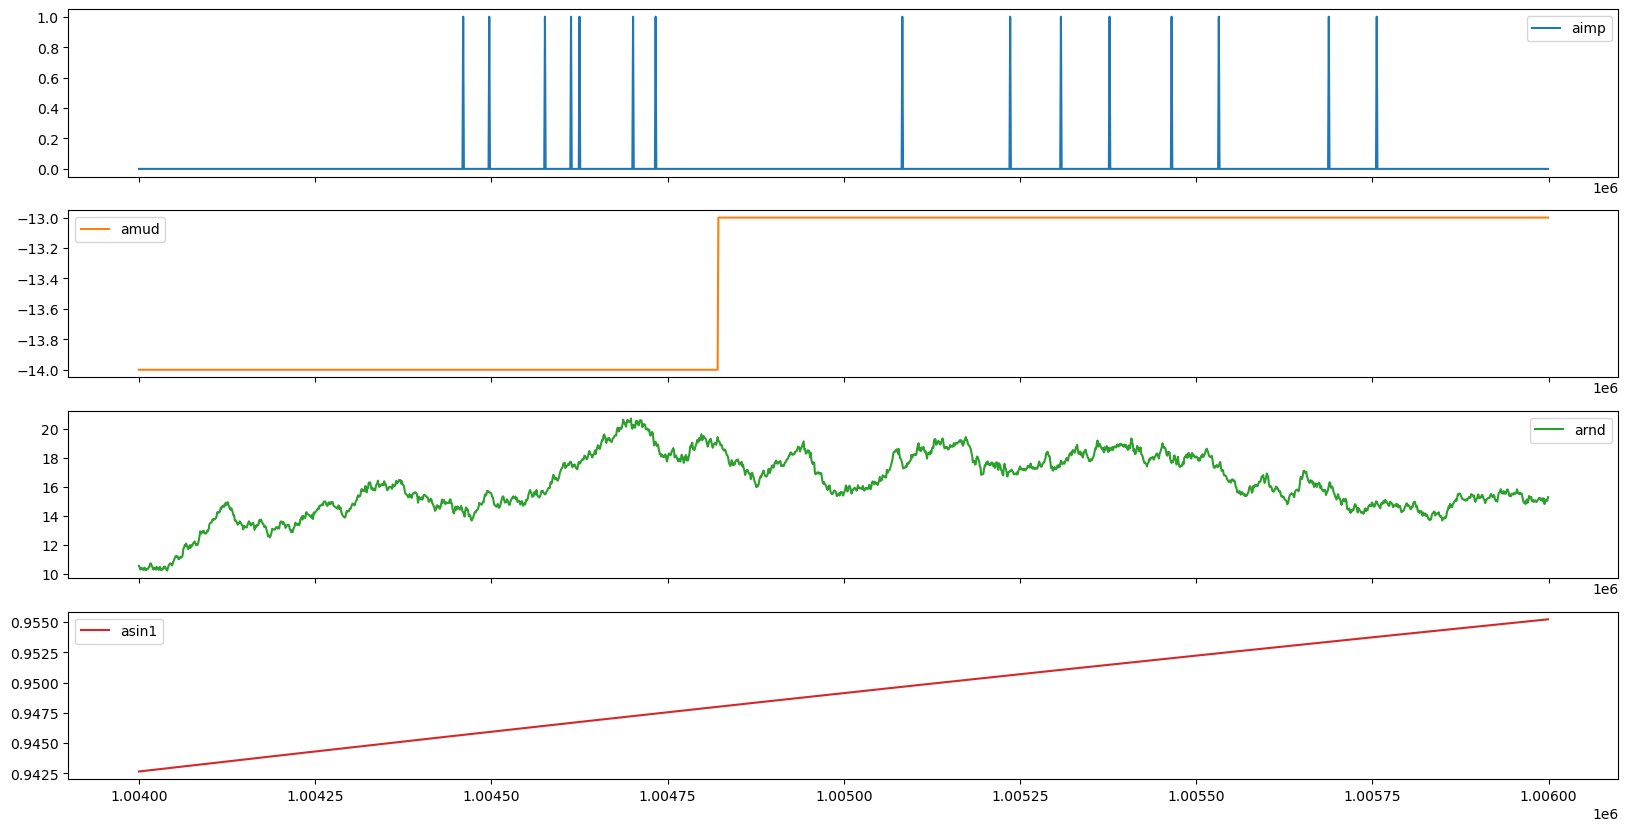

In [22]:
df.iloc[1_004_000:1_006_000, 1:5].plot(subplots=True)

In [27]:
np.nonzero(df["is_anomaly"].values)[0]

array([1005105, 1005106, 1005107, ..., 4982551, 4982552, 4982553])